In [1]:
import tensorflow as tf
import os
import shutil
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns
import scikitplot as skplt
from sklearn.metrics import classification_report
import sklearn
np.random.seed(42)

Changes from previous version: An extremely primitive and crude ensemble learning model for CLL and COVID only with CDR3's (and healthy sequences, acting as the control)

In [2]:
# Note that row 10467 of the cll-19 sequences was deleted due to having an empty HCDR3. The total number of cll-19 samples is now 11,867

In [3]:
tf.__version__

'2.10.0'

# CLL Model

# Preprocessing

In [4]:
head = []
with open("../Data/cAb-rep/cAb-Rep_heavy.nt.txt") as myfile:
    for i in myfile:
        if i.find("cdr3_aa_seq=") != -1:
            if (len(i.split('cdr3_aa_seq=')[-1].split('size=')[0]) > 28):
                continue
            head.append(i.split('cdr3_aa_seq=')[-1].split('size=')[0])
    np.random.shuffle(head)
    head = head[:1095]
print(head[:5], len(head))
healthy_sequences = head

['AKGDPGTKVTTNYYGMDV ', 'ARAPVCGGDCYYFDY ', 'ARGGDGYEFDY ', 'CARHIEAIGSVGFDLW\n', 'CARDLAAVAIDPW\n'] 1095


In [5]:
df = pd.read_excel("../Data/CLL/BCellStereotype2012-1.xlsx")
df = df["VH CDR3 sequence"]
df = df.str.upper()
df
# df = pd.read_csv("../Data/CoV-AbDab_031022.csv")
# df = df["CDRH3"]
# df = df.truncate(before=0, after=1094)
# df

0       ARDVDYYDSSGYYRYYYYGMDV
1       ARENGYDFWSGYYGDPYYGMDV
2       AVADYDFWSGYYPNYYYYGMDV
3       ARDKDYDFWSGYYDYYYYGMDV
4       ARLQYDFWSGYLNYYYYYGMDV
                 ...          
1090            ARGANGAVAGTFDY
1091            ARGTPGDYSRPFDY
1092            ARGCAGDYIFPFDY
1093            AKDSAGDYVFPMTY
1094            AKGPRGDYVSAFDI
Name: VH CDR3 sequence, Length: 1095, dtype: object

In [6]:
cll_sequences = df.to_numpy()
cll_sequences = np.squeeze(cll_sequences)
# print(healthy_sequences)
print(len(max(healthy_sequences, key=len)))
print(len(max(cll_sequences, key=len)))

# print(cll_sequences)

27
27


In [7]:
# order from https://www.ncbi.nlm.nih.gov/Class/MLACourse/Modules/MolBioReview/iupac_aa_abbreviations.html

In [8]:
cll_onehot = []
healthy_onehot = []

order = "ARNDCQEGHILKMFPSTWYV"

for i in cll_sequences:
    i = i.strip()
    count = 0
    b = np.zeros((27, 20))
    for j in i:
        b[count, order.index(j)] = 1
        count+=1
    cll_onehot.append(b)

# print(cll_onehot)

unique_aa = []

for i in healthy_sequences:
    i = i.strip()
    count = 0
    b = np.zeros((27, 20))
    unique_aa = list(set(i)) + list(set(unique_aa))
    for j in i:
        b[count, order.index(j)] = 1
        count+=1
    healthy_onehot.append(b)
    
# print(set(unique_aa))

# print(healthy_onehot)

print(len(cll_onehot))

# set infected 1, healthy 0

1095


In [9]:
healthy_lables = [0] * 1095
cll_lables = [1] * 1095

In [10]:
X = np.concatenate((healthy_onehot, cll_onehot))
y = np.concatenate((healthy_lables, cll_lables))

In [11]:
X_train_cll, X_test_cll, y_train_cll, y_test_cll = train_test_split(X, y, test_size=0.1, random_state=42)
    
X_train_cll, X_val_cll, y_train_cll, y_val_cll = train_test_split(X_train_cll, y_train_cll, test_size=0.1, random_state=42)

In [12]:
print(np.shape(X_train_cll), np.shape(y_train_cll))

(1773, 27, 20) (1773,)


# Model

In [13]:
model_cll = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(27, 20)),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5, seed=42),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(0.5, seed=42),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-01-10 21:48:46.594884: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-10 21:48:46.595045: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
model_cll.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [15]:
history = model_cll.fit(X_train_cll, y_train_cll, epochs=25, validation_data = (X_val_cll, y_val_cll))

Epoch 1/25


2023-01-10 21:48:46.932410: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-10 21:48:47.397449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - ETA: 0s - loss: 0.5115 - accuracy: 0.7394

2023-01-10 21:48:49.916136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - 3s 26ms/step - loss: 0.5115 - accuracy: 0.7394 - val_loss: 0.1795 - val_accuracy: 0.9040
Epoch 2/25
56/56 [==============================] - 1s 13ms/step - loss: 0.1737 - accuracy: 0.9397 - val_loss: 0.1275 - val_accuracy: 0.9596
Epoch 3/25
56/56 [==============================] - 1s 12ms/step - loss: 0.0679 - accuracy: 0.9763 - val_loss: 0.1236 - val_accuracy: 0.9545
Epoch 4/25
56/56 [==============================] - 1s 13ms/step - loss: 0.0370 - accuracy: 0.9882 - val_loss: 0.0970 - val_accuracy: 0.9596
Epoch 5/25
56/56 [==============================] - 1s 12ms/step - loss: 0.0137 - accuracy: 0.9955 - val_loss: 0.1422 - val_accuracy: 0.9596
Epoch 6/25
56/56 [==============================] - 1s 11ms/step - loss: 0.0055 - accuracy: 0.9989 - val_loss: 0.0987 - val_accuracy: 0.9798
Epoch 7/25
56/56 [==============================] - 1s 11ms/step - loss: 0.0055 - accuracy: 0.9972 - val_loss: 0.1014 - val_accuracy: 0.9697
Epoch 8/25
56/56 [======

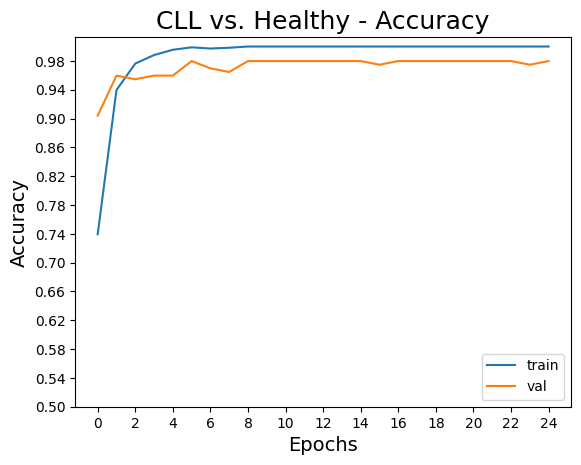

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CLL vs. Healthy - Accuracy', fontsize=18)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.yticks(np.arange(0.5, 1.0, 0.04))
plt.xticks(np.arange(0, 26, 2.0))
plt.legend(['train', 'val'], loc='lower right')
plt.show()

# Testing

In [17]:
model_cll.evaluate(X_test_cll, y_test_cll)

7/7 [==============================] - 0s 15ms/step - loss: 0.2512 - accuracy: 0.9726


[0.25118622183799744, 0.9726027846336365]

In [17]:
y_pred = []
y_true = y_test_cll
# for i in X_test: print(i[:3000], "\n")

for i in X_test_cll:
    i = np.expand_dims(i, axis=0)
    y_pred.append(np.round(model_cll.predict(i)))

y_pred

1/1 [==============================] - 0s 13ms/step


2022-12-06 09:05:37.037967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 14ms/step


[array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([

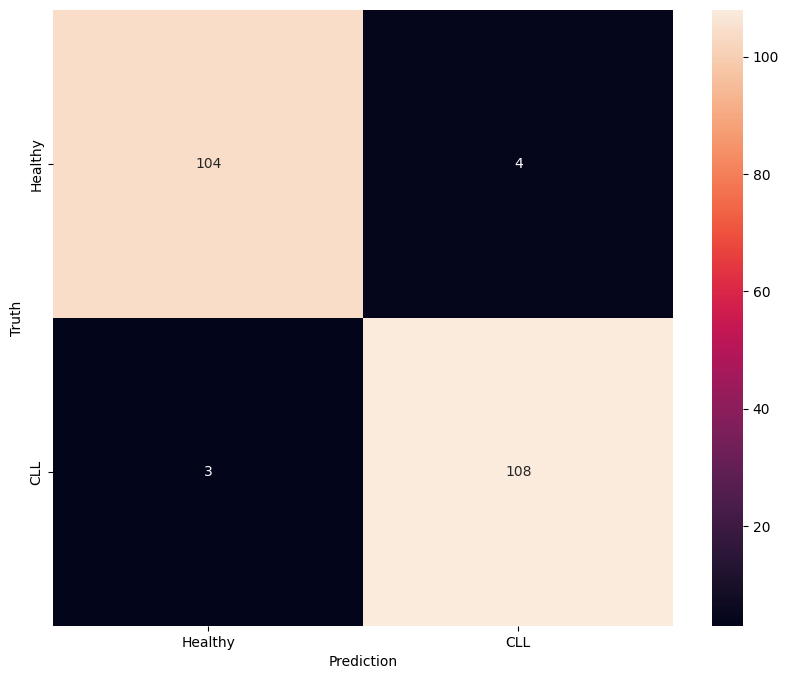

tf.Tensor(
[[104   4]
 [  3 108]], shape=(2, 2), dtype=int32)


In [18]:
correct_labels = np.array(tf.concat([item for item in y_true], axis = 0))
predicted_labels = np.array(tf.concat([item for item in y_pred], axis = 0))

confusion_mtx = tf.math.confusion_matrix(correct_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=["Healthy", "CLL"],
            yticklabels=["Healthy", "CLL"],
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()

print(confusion_mtx)

In [19]:
tf.math.confusion_matrix([0, 0, 0, 0, 0], [1, 1, 1, 1, 1]) # represents # of false positives (0 actual 1 pred)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[0, 5],
       [0, 0]], dtype=int32)>

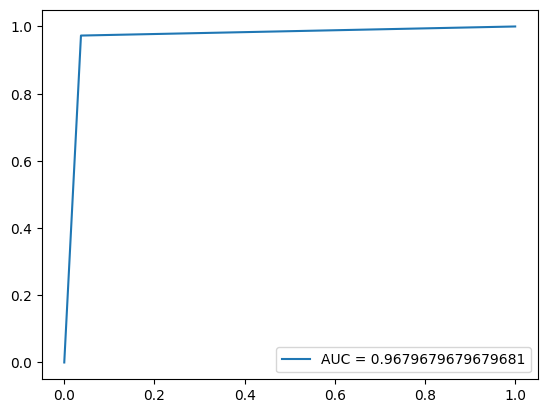

In [20]:
fpr, tpr, _ = sklearn.metrics.roc_curve(correct_labels,  predicted_labels)
auc = sklearn.metrics.roc_auc_score(correct_labels, predicted_labels)
plt.plot(fpr,tpr,label="AUC = "+str(auc))
plt.legend(loc=4)
plt.show()

# COVID-19 Model
Healthy sequences already preprocessed

In [21]:
df = pd.read_csv("../Data/CoV-AbDab_031022.csv")
df = df["CDRH3"]
df = df.str.upper()
df = df[df.apply(lambda x: len(x) <= 27)]
df = df.apply(lambda x: x.strip())
df

0             ARGQLGPWVGVDY
1              ARQGWLRGNFDY
2              ASQLWLRGAFDI
3              ARKGWLRGAFDI
4              ARKGWLRGAFDI
                ...        
11862      ARDRFGEFIYPGALDI
11863         AAMVRGGWWYFDL
11864     ASDPGGLSELAAEYFHH
11865        ARESTEVTHWYFDL
11866    ARQLLFFGDLSGDNGMDV
Name: CDRH3, Length: 11839, dtype: object

In [22]:
covid_sequences = df.to_numpy()
covid_sequences = np.squeeze(covid_sequences)
np.random.shuffle(covid_sequences)
covid_sequences = covid_sequences[:1095]
# print(healthy_sequences)
print(len(max(healthy_sequences, key=len)))
print(len(max(covid_sequences, key=len)))
# print(covid_sequences)

27
27


In [23]:
# order from https://www.ncbi.nlm.nih.gov/Class/MLACourse/Modules/MolBioReview/iupac_aa_abbreviations.html

In [24]:
covid_onehot = []
healthy_onehot = []

order = "ARNDCQEGHILKMFPSTWYV"

for i in covid_sequences:
    count = 0
    b = np.zeros((27, 20))
    for j in i:
        b[count, order.index(j)] = 1
        count+=1
    covid_onehot.append(b)

# print(covid_onehot)

unique_aa = []

for i in healthy_sequences:
    i = i.strip()
    count = 0
    b = np.zeros((27, 20))
    unique_aa = list(set(i)) + list(set(unique_aa))
    for j in i:
        b[count, order.index(j)] = 1
        count+=1
    healthy_onehot.append(b)
    
# print(set(unique_aa))

# print(healthy_onehot)

print(len(covid_onehot))

# set infected 1, healthy 0

1095


In [25]:
healthy_lables = [0] * 1095
covid_lables = [1] * 1095

In [26]:
X = np.concatenate((healthy_onehot, covid_onehot))
y = np.concatenate((healthy_lables, covid_lables))

In [27]:
X_train_covid, X_test_covid, y_train_covid, y_test_covid = train_test_split(X, y, test_size=0.1, random_state=42)
    
X_train_covid, X_val_covid, y_train_covid, y_val_covid = train_test_split(X_train_covid, y_train_covid, test_size=0.1, random_state=42)

In [28]:
model_covid = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(27, 20)),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [29]:
model_covid.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [30]:
history = model_covid.fit(X_train_covid, y_train_covid, epochs=25, validation_data = (X_val_covid, y_val_covid))

Epoch 1/25


2022-12-06 09:05:45.867754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - 1s 14ms/step - loss: 0.6683 - accuracy: 0.5307 - val_loss: 0.5708 - val_accuracy: 0.6667
Epoch 2/25
 1/56 [..............................] - ETA: 0s - loss: 0.6265 - accuracy: 0.6562

2022-12-06 09:05:46.753739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - 1s 9ms/step - loss: 0.5415 - accuracy: 0.7327 - val_loss: 0.5206 - val_accuracy: 0.7424
Epoch 3/25
56/56 [==============================] - 1s 10ms/step - loss: 0.5217 - accuracy: 0.7614 - val_loss: 0.5269 - val_accuracy: 0.7172
Epoch 4/25
56/56 [==============================] - 1s 9ms/step - loss: 0.5018 - accuracy: 0.7699 - val_loss: 0.5472 - val_accuracy: 0.6919
Epoch 5/25
56/56 [==============================] - 0s 9ms/step - loss: 0.4808 - accuracy: 0.7857 - val_loss: 0.5422 - val_accuracy: 0.7020
Epoch 6/25
56/56 [==============================] - 0s 8ms/step - loss: 0.4631 - accuracy: 0.8009 - val_loss: 0.5869 - val_accuracy: 0.6970
Epoch 7/25
56/56 [==============================] - 1s 9ms/step - loss: 0.4460 - accuracy: 0.8111 - val_loss: 0.5787 - val_accuracy: 0.6970
Epoch 8/25
56/56 [==============================] - 1s 11ms/step - loss: 0.4360 - accuracy: 0.8195 - val_loss: 0.6172 - val_accuracy: 0.7121
Epoch 9/25
56/56 [===========

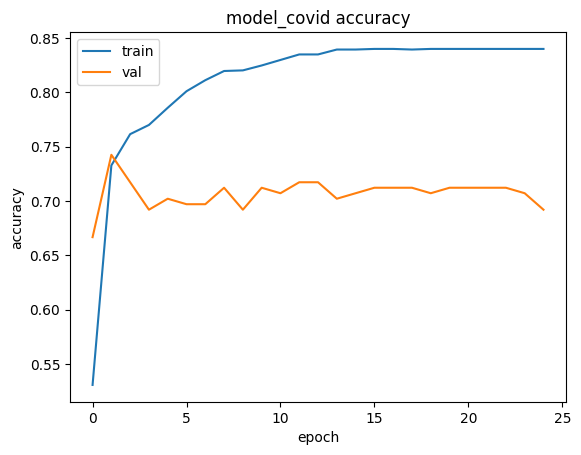

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model_covid accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [32]:
model_covid.evaluate(X_test_covid, y_test_covid)

7/7 [==============================] - 0s 10ms/step - loss: 0.8468 - accuracy: 0.7626


[0.8467578887939453, 0.7625571489334106]

In [33]:
y_pred = []
y_true = y_test_covid
# for i in X_test: print(i[:3000], "\n")

for i in X_test_covid:
    i = np.expand_dims(i, axis=0)
    y_pred.append(np.round(model_covid.predict(i)))

y_pred

1/1 [==============================] - 0s 13ms/step


2022-12-06 09:05:59.900748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 13ms/step


[array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([

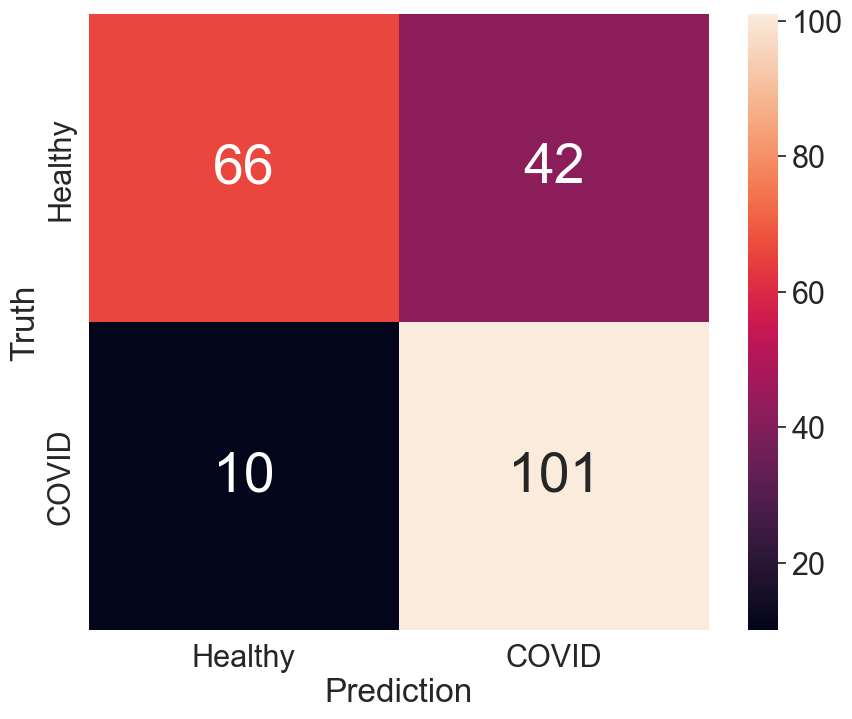

tf.Tensor(
[[ 66  42]
 [ 10 101]], shape=(2, 2), dtype=int32)


In [34]:
correct_labels = np.array(tf.concat([item for item in y_true], axis = 0))
predicted_labels = np.array(tf.concat([item for item in y_pred], axis = 0))

confusion_mtx = tf.math.confusion_matrix(correct_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.set(font_scale=2)
sns.heatmap(confusion_mtx,
            xticklabels=["Healthy", "COVID"],
            yticklabels=["Healthy", "COVID"],
            annot=True, fmt='g', annot_kws={"size":40})
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()

print(confusion_mtx)

In [35]:
tf.math.confusion_matrix([0, 0, 0, 0, 0], [1, 1, 1, 1, 1]) # represents # of false positives (0 actual 1 pred)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[0, 5],
       [0, 0]], dtype=int32)>

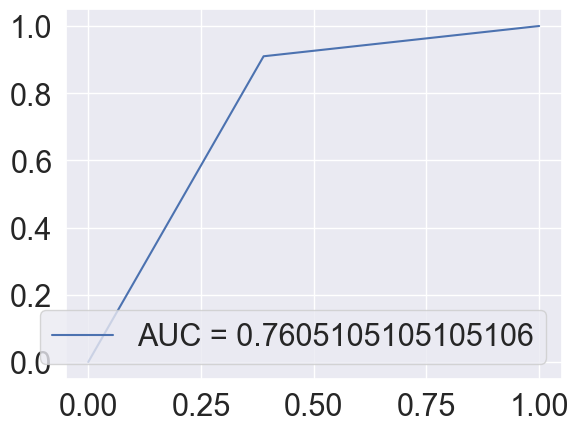

In [36]:
fpr, tpr, _ = sklearn.metrics.roc_curve(correct_labels,  predicted_labels)
auc = sklearn.metrics.roc_auc_score(correct_labels, predicted_labels)
plt.plot(fpr,tpr,label="AUC = "+str(auc))
plt.legend(loc=4)
plt.show()

In [37]:
models = [model_covid, model_cll]

In [38]:
y_pred_ensemble = []
y_true_ensemble = np.concatenate((y_test_covid, list(map(lambda x: 2 if x == 1 else 0, y_test_cll))))
X_test_ensemble = np.concatenate((X_test_covid, X_test_cll))
# for i in X_test: print(i[:3000], "\n")

for i in X_test_ensemble:
    i = np.expand_dims(i, axis=0)
    yhats = [model.predict(i) for model in models]
    if max(yhats) > 0.5:
        if np.argmax(yhats) == 0:
            # print("covid")
            y_pred_ensemble.append(1)
        else:
            y_pred_ensemble.append(2)
    else:
        # print("healthy")
        y_pred_ensemble.append(0)
    # print(yhats)
    # y_pred.append(np.round(model.predict(i)))

1/1 [==============================] - 0s 13ms/step


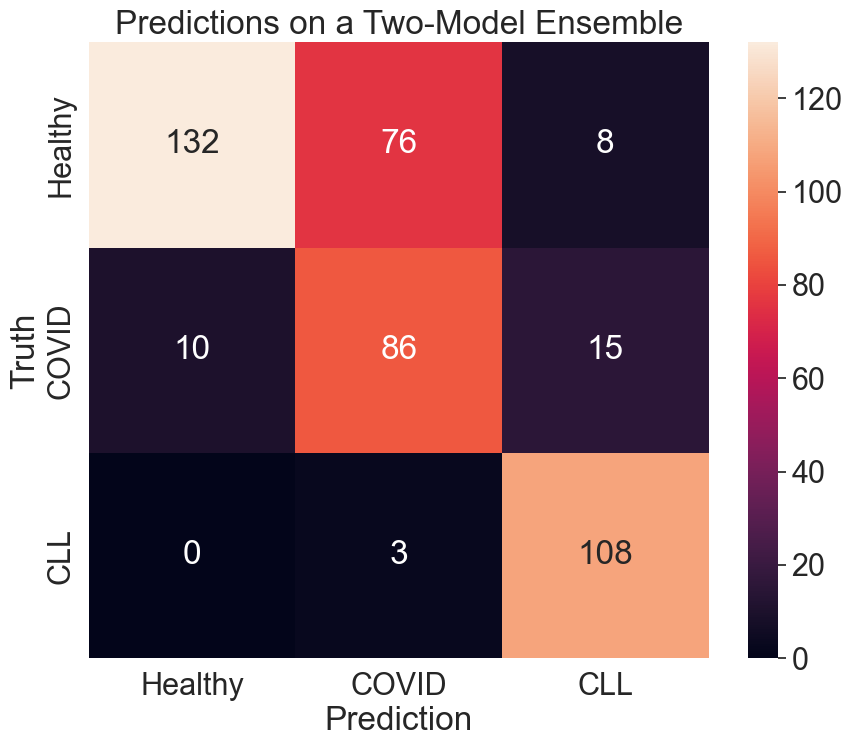

tf.Tensor(
[[132  76   8]
 [ 10  86  15]
 [  0   3 108]], shape=(3, 3), dtype=int32)


In [39]:
correct_labels = np.array(tf.concat([item for item in y_true_ensemble], axis = 0))
predicted_labels = np.array(tf.concat([item for item in y_pred_ensemble], axis = 0))

confusion_mtx = tf.math.confusion_matrix(correct_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=["Healthy", "COVID", "CLL"],
            yticklabels=["Healthy", "COVID", "CLL"],
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.title("Predictions on a Two-Model Ensemble")
plt.show()

print(confusion_mtx)

In [40]:
print(len(y_pred_ensemble))

438


In [41]:
print((146+74+94)/438) # accuracy of ensemble. wahoo!

# also, if you ignore healthy sequences (since those were kind of like our control) and just focus on the bottom right 4 squares, you get 88.4% accuracy. Actually, this value isn't very useful

0.7168949771689498


In [46]:
test = sklearn.metrics.confusion_matrix(y_true_ensemble, y_pred_ensemble).ravel()
print(test)

print(sklearn.metrics.classification_report([132,  76,   8,  10,  86,  15,   0,  3, 108], digits=4))

[132  76   8  10  86  15   0   3 108]


TypeError: classification_report() missing 1 required positional argument: 'y_pred'